# **MELANOMA DETECTION ASSIGNMENT**

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



## Importing Skin Cancer Data

In [ ]:
# Importing all the necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/load_data/CNN_assignment.zip -d /content/gdrive/MyDrive/load_data/CNN_Assignment

Archive:  /content/gdrive/MyDrive/load_data/CNN_assignment.zip
replace /content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Defining the path for train and test images
data_train = pathlib.Path("/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_test = pathlib.Path('/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Keras pre-processing.
Let's load these images off disk using the helpful image_dataset_from_directory utility.

# Create a dataset
Let's define some parameters for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
## Preparaing Train Dataset
## Using seed=123
train_data_set = tf.keras.preprocessing.image_dataset_from_directory( data_train, seed=123, validation_split = 0.2,
            subset = 'training', image_size=(img_height, img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Preparaing Validation Dataset
val_data_set = tf.keras.preprocessing.image_dataset_from_directory(data_train, seed=123,validation_split = 0.2,
         subset = 'validation', image_size=(img_height, img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Printing class names of train data set
class_names = train_data_set.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Checking type of train data set
print(type(train_data_set))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# Let's print images with their respective labels
for images, labels in train_data_set.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


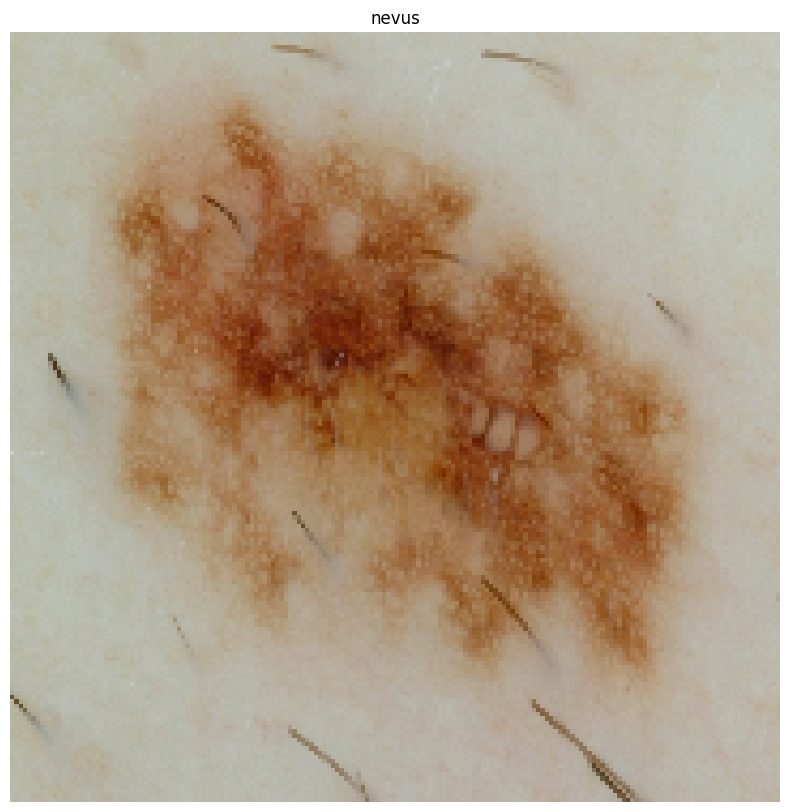

In [ ]:
# Visualizing single instance of the image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_data_set.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


# Visualize the data


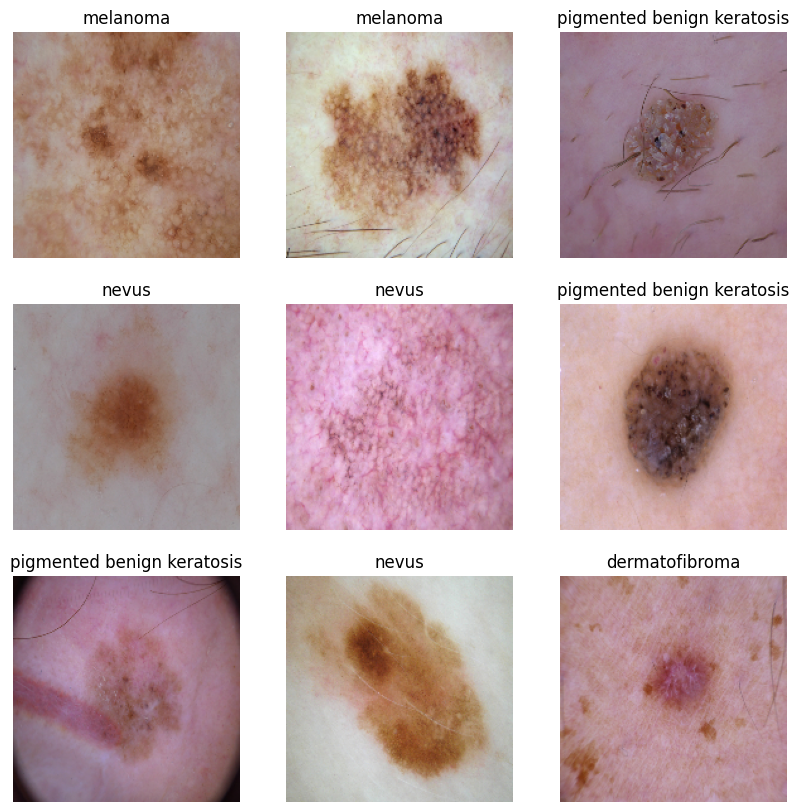

In [ ]:
# Visualizing one instance of all the nine classes present in the train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_data_set.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

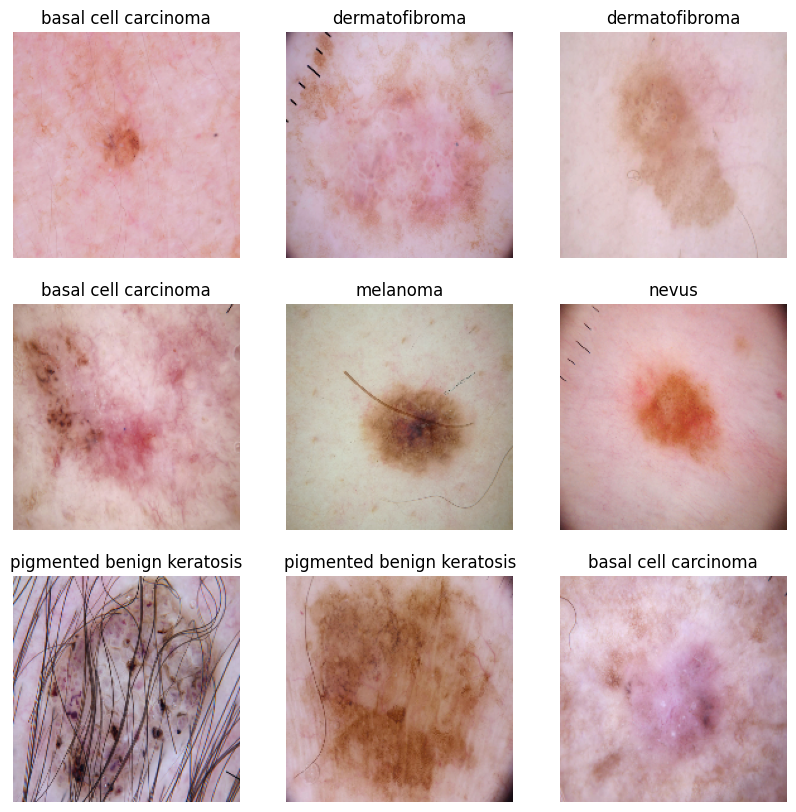

In [ ]:
# Visualizing one instance of all the nine classes present in the validation dataset
plt.figure(figsize=(10, 10))
for images, labels in val_data_set.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(type(train_data_set))
print(len(train_data_set))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56


A tensor with the shape (32, 180, 180, 3) is the image_batch. This is a set of 32 images of shape (180x180x3), where the final dimension is the RGB colour channels. The labels for the 32 images correspond to the label_batch, which is a tensor of the shape (32,).

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_set = train_data_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data_set = val_data_set.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

A tensor with the shape (32, 180, 180, 3) is the image_batch. This is a set of 32 (180x180x3) images, where the final dimension is
the RGB colour channels. The labels for the 32 images correspond to the label_batch, which is a tensor of the shape (32,).

In [ ]:
# Total classes
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # We slide over the feature map and extract tiles of a specified size.
  # Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  # We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  # We slide over the feature map and extract tiles of a specified size.
  # Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  # Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ## Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  # fully connected layer
  # A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  # A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  # Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  # It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  # Dense implements the operation: output = activation(dot(input, kernel)
  # Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  # Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

## Compiling the model

In [ ]:
# Let's view the summary of all layers
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Let's fit the model using '20' epochs
epochs = 20
history = model.fit(train_data_set, validation_data=val_data_set, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 239s 1s/step - loss: 2.0683 - accuracy: 0.2193 - val_loss: 1.9195 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 58s 1s/step - loss: 1.8037 - accuracy: 0.3253 - val_loss: 1.6841 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 61s 1s/step - loss: 1.5433 - accuracy: 0.4509 - val_loss: 1.3999 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 59s 1s/step - loss: 1.3757 - accuracy: 0.5134 - val_loss: 1.4833 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 63s 1s/step - loss: 1.2673 - accuracy: 0.5580 - val_loss: 1.3748 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 60s 1s/step - loss: 1.2288 - accuracy: 0.5658 - val_loss: 1.3782 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 59s 1s/step - loss: 1.1407 - accuracy: 0.5938 - val_loss: 1.3439 - val_accuracy: 0.5570
Epoch 8/20
56/56 [=

## Training the model

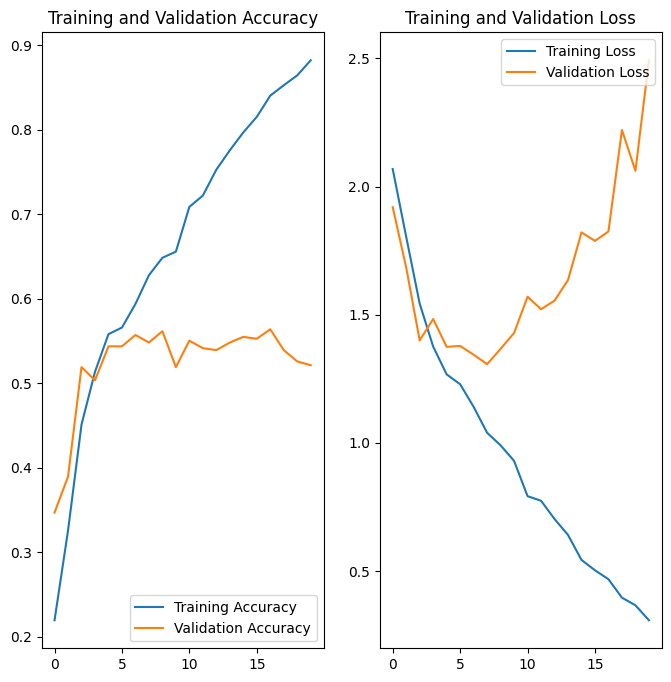

In [ ]:
# Train the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

Findings from the above observation:


*   The model is overfitting because there is difference in loss
     functions in training & test.
*   The accuracy is just around low because there are enough features to   
     remember the pattern.
*   Besides this, it is hard to find wheather the model overfit or underfit.

Let's do some data augmentation to find more accuracy.





# Visualizing training results

Data augmentation: Data augmentation can address a variety of challenges when training a CNN model, such as limited or imbalanced data, overfitting, and variation and complexity. This technique can increase the size of the dataset and balance the classes by applying different transformations.

In [ ]:
# Lets see the distribution of augmented data after adding new images to the original training data.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

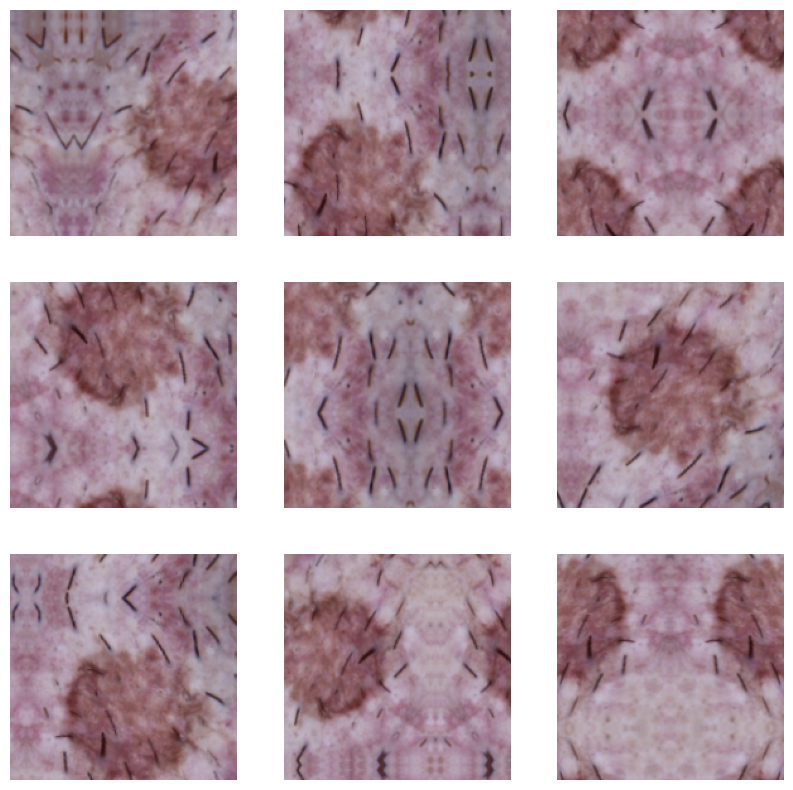

In [ ]:
# Visualizing the augmentation strategy for one instance of image
plt.figure(figsize=(10, 10))
for images, _ in train_data_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creating the model, compiling and training  the model



In [ ]:
# Creating the model
# Using dropout as we some evidences of overfitting.
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:


# Training the model
epochs = 20
history = model.fit(train_data_set,
  validation_data=val_data_set,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 389s 7s/step - loss: 2.1324 - accuracy: 0.2054 - val_loss: 1.9691 - val_accuracy: 0.2528
Epoch 2/20
56/56 [==============================] - 400s 7s/step - loss: 1.9478 - accuracy: 0.2472 - val_loss: 1.9186 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 402s 7s/step - loss: 1.9873 - accuracy: 0.2416 - val_loss: 1.9776 - val_accuracy: 0.2438
Epoch 4/20
56/56 [==============================] - 397s 7s/step - loss: 1.9109 - accuracy: 0.2528 - val_loss: 1.8976 - val_accuracy: 0.2886
Epoch 5/20
56/56 [==============================] - 402s 7s/step - loss: 1.8779 - accuracy: 0.2706 - val_loss: 1.8619 - val_accuracy: 0.2841
Epoch 6/20
56/56 [==============================] - 391s 7s/step - loss: 1.8094 - accuracy: 0.3103 - val_loss: 1.7117 - val_accuracy: 0.3647
Epoch 7/20
56/56 [==============================] - 387s 7s/step - loss: 1.6939 - accuracy: 0.3521 - val_loss: 1.6355 - val_accuracy: 0.3579
Epoch 8/20
56

In [ ]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
train_data_set = pathlib.Path("/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_set = pathlib.Path('/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# Building CNN with TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
# https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_data_set,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=test_data_set,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
#Creating a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Importing layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 235s 10s/step - loss: 2.3430 - accuracy: 0.2211 - val_loss: 2.1427 - val_accuracy: 0.1864
Epoch 2/10
23/23 [==============================] - 182s 8s/step - loss: 1.7924 - accuracy: 0.3381 - val_loss: 2.0452 - val_accuracy: 0.2288
Epoch 3/10
23/23 [==============================] - 182s 8s/step - loss: 1.6447 - accuracy: 0.4002 - val_loss: 2.1620 - val_accuracy: 0.2288
Epoch 4/10
23/23 [==============================] - 180s 8s/step - loss: 1.5169 - accuracy: 0.4721 - val_loss: 2.0103 - val_accuracy: 0.3220
Epoch 5/10
23/23 [==============================] - 180s 8s/step - loss: 1.4807 - accuracy: 0.4792 - val_loss: 2.1695 - val_accuracy: 0.3475
Epoch 6/10
23/23 [==============================] - 182s 8s/step - loss: 1.4310 - accuracy: 0.5065 - val_loss: 2.1034 - val_accuracy: 0.3729
Epoch 7/10
23/23 [==============================] - 181s 8s/step - loss: 1.3666 - accuracy: 0.5226 - val_loss: 2.4271 - val_accuracy: 0.3051
Epoch 8/10
2

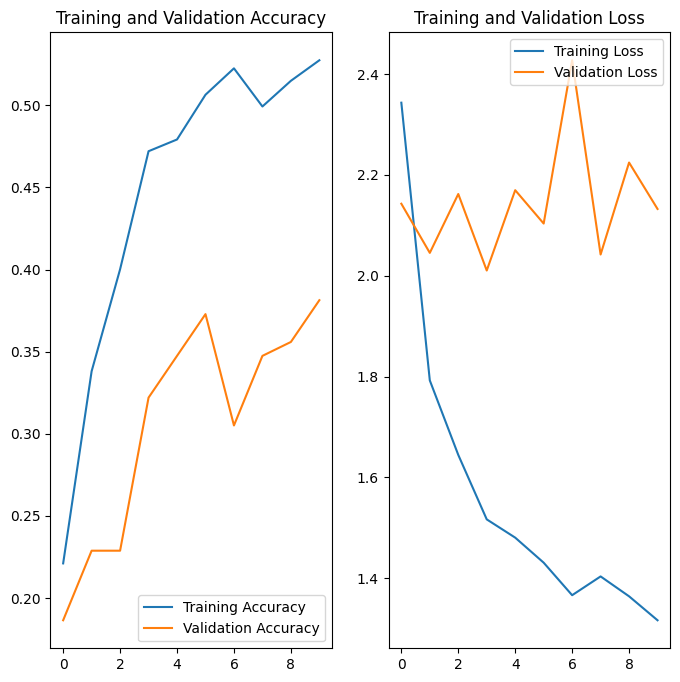

In [ ]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/load_data/CNN_Assignme...,actinic keratosis
1,/content/gdrive/MyDrive/load_data/CNN_Assignme...,actinic keratosis
2,/content/gdrive/MyDrive/load_data/CNN_Assignme...,actinic keratosis
3,/content/gdrive/MyDrive/load_data/CNN_Assignme...,actinic keratosis
4,/content/gdrive/MyDrive/load_data/CNN_Assignme...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/load_data/CNN_Assignme...,vascular lesion
2235,/content/gdrive/MyDrive/load_data/CNN_Assignme...,vascular lesion
2236,/content/gdrive/MyDrive/load_data/CNN_Assignme...,vascular lesion
2237,/content/gdrive/MyDrive/load_data/CNN_Assignme...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


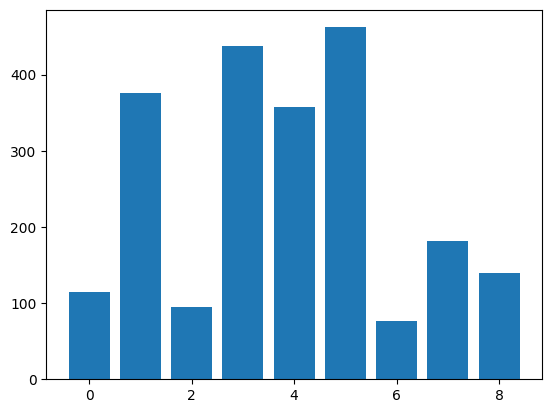

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
!pip install Augmentor

In [ ]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = r'/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(150)
p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8B87B3EB60>: 100%|██████████| 150/150 [00:46<00:00,  3.26 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8B877F3100>: 100%|██████████| 114/114 [00:05<00:00, 20.52 Samples/s]


We use Data Augementator
Following general procedure is followed:

By Instantiating a Pipeline object pointing to a directory containing initial image data set.
Defining a number of operations to perform on this data set using Pipeline object.
Executing these operations by calling the Pipeline’s sample() method.

In [76]:
path_to_training_dataset="/content/gdrive/MyDrive/upgrad/Train/CNN_assignment//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [58]:
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

264


In [59]:
path_list_new = [x for x in glob(os.path.join(data_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_efc08774-4f88-4b05-b7a7-34a126182447.jpg',
 '/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_ef5dea4d-05cd-4447-9d38-5c0554299660.jpg',
 '/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_3a134c7a-155e-4fce-9d36-13fbe3e7c192.jpg',
 '/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_bc87d3ab-9539-4ee4-a5f3-be1a03f0ba6a.jpg',
 '/content/gdrive/MyDrive/load_data/CNN_Assignment/Skin cancer ISIC The Inte

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-62-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [63]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
actinic keratosis             378
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [64]:
batch_size = 32
img_height = 180
img_width = 180

In [65]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2503 files belonging to 9 classes.
Using 2003 files for training.


In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2503 files belonging to 9 classes.
Using 500 files for validation.


 **Normalization Model**

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiling model using optimizer and loss function appropriately

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
# Training model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 105s 1s/step - loss: 2.0427 - accuracy: 0.2202 - val_loss: 1.7964 - val_accuracy: 0.3260
Epoch 2/20
63/63 [==============================] - 66s 1s/step - loss: 1.7234 - accuracy: 0.3655 - val_loss: 1.6196 - val_accuracy: 0.4300
Epoch 3/20
63/63 [==============================] - 67s 1s/step - loss: 1.5321 - accuracy: 0.4643 - val_loss: 1.5130 - val_accuracy: 0.4540
Epoch 4/20
63/63 [==============================] - 67s 1s/step - loss: 1.4355 - accuracy: 0.4973 - val_loss: 1.5105 - val_accuracy: 0.4500
Epoch 5/20
63/63 [==============================] - 64s 1s/step - loss: 1.3211 - accuracy: 0.5402 - val_loss: 1.4193 - val_accuracy: 0.5120
Epoch 6/20
63/63 [==============================] - 64s 1s/step - loss: 1.2283 - accuracy: 0.5761 - val_loss: 1.3686 - val_accuracy: 0.5500
Epoch 7/20
63/63 [==============================] - 66s 1s/step - loss: 1.2065 - accuracy: 0.5691 - val_loss: 1.4412 - val_accuracy: 0.5200
Epoch 8/20
63/63 [=

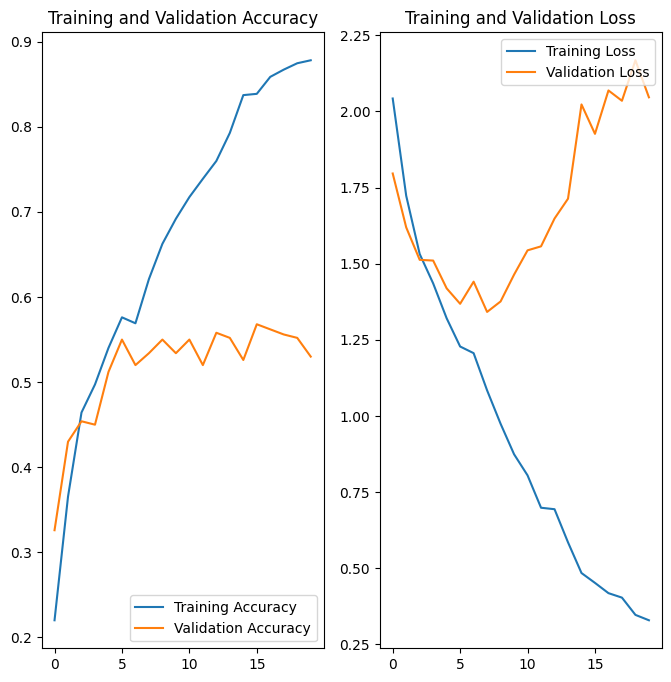

In [70]:
# Visualizing the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Prediction

1/1 [==============================] - 0s 28ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


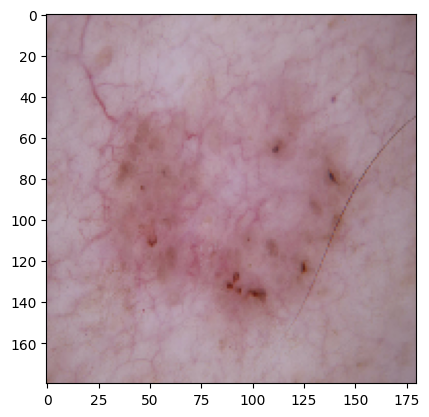

In [73]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
Test_image_path = os.path.join(data_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )